# This notebooks does predictive modeling of the Output : "Is there any Choke Hazard?" in the FSHA form 
# This notebook applies basic ML techniques like NaiveBayesClassifier, LogisticRegression, SGDClassifier on the concatenated text derived from the set of features. The text is cleaned, normalized and then vectorized and fit into the Model. The target is upsampled to counter the unbalanced data ('Yes' / 'No' values), before applying ML

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
filename = "C:/Pepsico/FSHA RPA - 25 July 2019 - 209Files.xlsm"
#filename1 = "C:/Pepsico/NAF-2019 RPA - 09 AUGUST 2019.xlsm"
#filename2 = "C:/Pepsico/NAF-2018 RPA - 09 AUGUST 2019.xlsm"
#filename3 = "C:/Pepsico/Additional FSHAs.xlsm"
#filename4 = "C:/Pepsico/FSHA RPA - Microbial Growth = Y - 14 Aug 2019.xlsm"
#filename4 = "C:/Pepsico/NAF - Additional FSHAs 1 - 13 AUG 2019.xlsm"

In [3]:
filename0 = "C:/Pepsico/choke hazards_08 26.xlsm"

In [4]:
df_chokeHazard_no = pd.read_excel(filename)

In [5]:
len(df_chokeHazard_no)

209

In [6]:
df_chokeHazard_yes = pd.read_excel(filename0)

In [7]:
len(df_chokeHazard_yes)

25

In [8]:
df_chokeHazard_no = df_chokeHazard_no[(df_chokeHazard_no.chokeHazard=='No')]

In [9]:
len(df_chokeHazard_no)

204

In [10]:
df =  pd.concat([df_chokeHazard_no,df_chokeHazard_yes])

In [11]:
len(df)

229

# Read the extract file, check the number of records, first few rows

In [12]:
df.iloc[0,:40]


CPD-ProdName                             1SKU Star Puffs Onion\n2 SKU Star Puffs Cheese...
CPD-ProdName-Desc                        Extruded and baked corn base product, flavoure...
Current TSG Stage                                                                       G3
FSAssessors                                                                   Helen Booden
FSDate                                                                          21/11/2017
File Name                                #46565 FSHA 5.4.1Star Project G3 v2 + FS input...
PDA_projName                             1SKU Star Puffs Onion\n2 SKU Star Puffs Cheese...
PlantTrial                                   Tomaszow plant, trial conducted on 02/11/2017
TCG                                         Families and Adults, value conscious consumers
Table1_Row1_Celery                                                                       0
Table1_Row1_Cereals containing Gluten                                                    0

# Select key features 

In [13]:

df.fillna('NA', inplace=True)
features_df=df[['projDesc','PDA_projName','packMaterial', 'CPD-ProdName','CPD-ProdName-Desc','TCG', 'labelingInstructions',
        'mishandled', 'targetMarket']]


In [14]:
def conv_str(x):
   
    x=str(x)
    x=x.lower()
    return (x)

features_df['projDesc']=features_df['projDesc'].apply(lambda x:conv_str(x))  
features_df['PDA_projName']=features_df['PDA_projName'].apply(lambda x:conv_str(x))
features_df['packMaterial']=features_df['packMaterial'].apply(lambda x:conv_str(x))  
features_df['CPD-ProdName']=features_df['CPD-ProdName'].apply(lambda x:conv_str(x))  
features_df['CPD-ProdName-Desc']=features_df['CPD-ProdName-Desc'].apply(lambda x:conv_str(x))  
features_df['TCG']=features_df['TCG'].apply(lambda x:conv_str(x)) 
features_df['labelingInstructions']=features_df['labelingInstructions'].apply(lambda x:conv_str(x)) 
features_df['mishandled']=features_df['mishandled'].apply(lambda x:conv_str(x))  
features_df['targetMarket']=features_df['targetMarket'].apply(lambda x:conv_str(x))  




# Concatenate the columns as one single text value

In [15]:
features_df['concat_text'] = features_df['projDesc']+" "+features_df['packMaterial']+" "+features_df['PDA_projName']+" "+features_df['CPD-ProdName']+" "+features_df['CPD-ProdName-Desc']+" "+features_df['TCG']+" "+features_df['labelingInstructions']+" "+features_df['mishandled']+" "+features_df['targetMarket']


# Find the number of tokens in the text

In [16]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

18265

We have over 18k words in the data.

# Find the value counts of target Field (Yes / No)

In [17]:
df.chokeHazard.value_counts()

No     204
Yes     25
Name: chokeHazard, dtype: int64

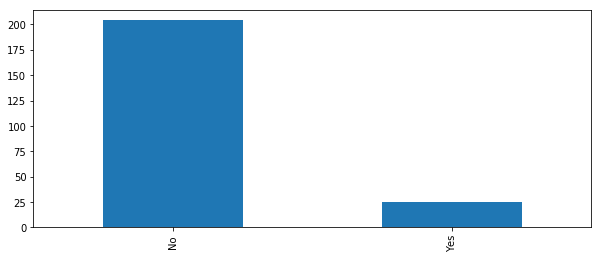

In [18]:
plt.figure(figsize=(10,4))
df.chokeHazard.value_counts().plot(kind='bar');

# Binarize the target, impute any missing value with the mode

In [19]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    #print(len(fsha_data))
    for i in range (len(fsha_data)):
        #print(i)
        ##print(fsha_data[targetName].values(i))
        if fsha_data[targetName].values[i]=='Yes':
            train_y.append(1)
        elif fsha_data[targetName].values[i]=='No':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

In [20]:

features_df["tags"] = impute_target(df,"chokeHazard")


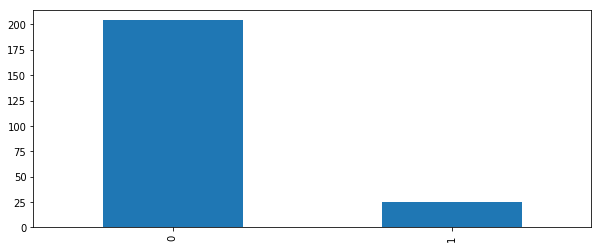

In [21]:
plt.figure(figsize=(10,4))
features_df.tags.value_counts().plot(kind='bar');

In [22]:
features_df.tags.value_counts()

0    204
1     25
Name: tags, dtype: int64

The classes are not balanced, but we see higher count of 1, based on new data

In [23]:
def print_plot(index):
    example = features_df[features_df.index == index][['concat_text', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

# Have a look a few concatenated text and target pairs.

In [24]:
print_plot(10)

5 christmas lto's 3 x npd 2 x l&s none walkers potato crisps walkers potato crisps potato crisps general population none no no
Tag: 0


In [25]:
print_plot(5)

cq93 product is a combination of 2 extruded and 1 fried pellet product with three different seasoning. new seaso ning will be applied on pellet. new seasoning allegren profile changed gluten added however the finished product pellet already contains gluten so no new risks itroduced.  na cerezza kokteyl extruded product tast mix up 2 extruded and 1 fried pellet product with three different seasoning. families with kids na no no
Tag: 0


# Clean the text (remove punctuation, symbols, lowercase etc)

In [26]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [27]:
features_df['concat_text'] = features_df['concat_text'].apply(clean_text)

# Check a sample row of cleaned text

In [28]:
print_plot(0)

star puffs cheese star hyper cheeseseasoning new seasoning ls seasoning 276030 cheese symrise previously existing tomaszow plant cheetos gigant delisted jan17 shape new shape barrel new equipment shape easily achieved using existing equipment speeding cutter star puffs onionseasoning existing seasoning cheetos green onion cq69 vegetable blend shape new shape barrel new equipment shape easily achieved using existing equipment speeding cutter none 1sku star puffs onion2 sku star puffs cheese 3 sku star hyper cheese 1sku star puffs onion2 sku star puffs cheese 3 sku star hyper cheese extruded baked corn base product flavoured seasoning oil mix families adults value conscious consumers star hyper cheesecheese flavoured maize snacks ingredients corn grits 70 vegetable rapeseed oil seasoning lactose milk salt flavourings contains milk flavour enhancers monosodium glutamate disodium guanylate disodium inosinate colours paprika extract product may contain peanutsstore dry cool away sun placebe

In [29]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

11886

# Train Test Split

In [30]:
X = features_df.concat_text
y = features_df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state = 42)

In [31]:
y_train.value_counts()

0    163
1     20
Name: tags, dtype: int64

In [32]:
y_test.value_counts()

0    41
1     5
Name: tags, dtype: int64

In [33]:
y_test = y_test.reset_index()
y_test = y_test['tags']

# Upsample the target data, since the data is highly imbalanced

In [34]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_chokeHazard = X[X.tags==0]
chokeHazard = X[X.tags==1]

In [35]:
len(not_chokeHazard)

163

In [36]:
len(chokeHazard)

20

In [37]:
# upsample minority
chokeHazard_upsampled = resample(chokeHazard,
                          replace=True, # sample with replacement
                          n_samples=len(not_chokeHazard), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([chokeHazard_upsampled, not_chokeHazard])

In [38]:
# check new class counts - now we have balanced data
upsampled.tags.value_counts()

1    163
0    163
Name: tags, dtype: int64

In [39]:
y_train = upsampled.tags
X_train = upsampled.drop('tags', axis=1)

In [40]:
y_train=y_train.reshape(y_train.shape[0],1)

In [41]:
y_train.shape

(326, 1)

In [42]:
X_train.shape

(326, 1)

In [43]:
X_train['concat_text'].values[5]

'seasoning development oil added product produced duyvis zaandam seasoning premixed maltodextrine salt rice flour seasoning diluted water stick directly roasted peanuts none oil added peanuts oil added peanuts roasted salted peanuts salt sticked maltodextrine peanuts way dont need stick salt via hoso oil peanuts therefore dont add oil peanuts applicable trial na whole peanuts suitable children 36 months'

In [44]:
X_train = X_train['concat_text'].values

In [45]:
X_train[5]

'seasoning development oil added product produced duyvis zaandam seasoning premixed maltodextrine salt rice flour seasoning diluted water stick directly roasted peanuts none oil added peanuts oil added peanuts roasted salted peanuts salt sticked maltodextrine peanuts way dont need stick salt via hoso oil peanuts therefore dont add oil peanuts applicable trial na whole peanuts suitable children 36 months'

In [46]:
X_test.values[0]

'lto poland hungary baltics produced poland chorizo onion spanish omlette tortilla flavour seasoning lift shit lift adapt none spanish omlette flavours potato chips spanish omlette flavours potato chips flat lays pc current lays na'

In [47]:
X_test = X_test.values

In [48]:
X_test[5]

'launch ls flavours ridged based none lays max bbq lays max bbq existing ridge base superchips seasoned seasoning fun times together na current pc products none'

In [49]:
y_train[5]

array([1], dtype=int64)

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers. 

### Naive Bayes classifier for multinomial models

In [50]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [51]:
%%time
from sklearn.metrics import classification_report,f1_score
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.98
f1-score 0.98
             precision    recall  f1-score   support

          0       1.00      0.98      0.99        41
          1       0.83      1.00      0.91         5

avg / total       0.98      0.98      0.98        46

Wall time: 16.8 ms


In [52]:
print(np.where(y_test==1))

(array([ 4, 21, 27, 28, 30], dtype=int64),)


In [53]:
print(np.where(y_pred==1))

(array([ 4, 21, 27, 28, 30, 41], dtype=int64),)


In [54]:
X = np.concatenate((X_train,X_test))

In [55]:
len(X)

372

In [56]:
X=X.reshape(X.shape[0],)

In [57]:
y_test=y_test.reshape(y_test.shape[0],1)

In [58]:
y = np.concatenate((y_train,y_test))

In [59]:
y=y.reshape(y.shape[0],)

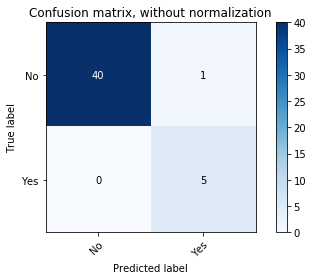

In [60]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
   # else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names=['No','Yes']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

In [61]:
from sklearn.model_selection import cross_validate
nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
cv_results = cross_validate(nb.fit(X, y), X, y,cv=5)

In [62]:
print(cv_results['test_score'])

[1.   1.   0.99 0.95 0.99]


# Let us check the feature importance plots for the choices Yes and No for the boolean ChokeHazard

after fit


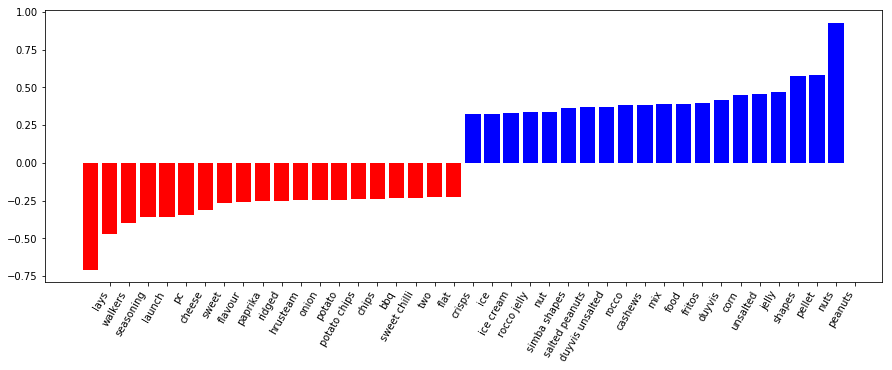

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer


def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()


tfidf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2))
features = tfidf.fit_transform(X)

svm = LinearSVC()
svm.fit(features, y)
print("after fit")
plot_coefficients(svm, tfidf.get_feature_names())

### SGDClassifier

In [64]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [65]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.98
f1-score 0.98
             precision    recall  f1-score   support

          0       1.00      0.98      0.99        41
          1       0.83      1.00      0.91         5

avg / total       0.98      0.98      0.98        46

Wall time: 10.5 ms


### Logistic regression

In [66]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [67]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.98
f1-score 0.98
             precision    recall  f1-score   support

          0       1.00      0.98      0.99        41
          1       0.83      1.00      0.91         5

avg / total       0.98      0.98      0.98        46

Wall time: 15.9 ms
